# ABET: MLP for pattern regression

*Author: Jorge Andrés Padilla*

In [1]:
from typing import Callable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Problem description

The Auto MPG dataset is a collection of data about cars and their fuel consumption. This version of the dataset contains 100 records, each one with 3 attributes. The attributes are:
- **Weight**: weight of the car.
- **Horsepower**: horsepower of the car.
- **MPG**: miles per gallon (fuel consumption), which will be the target of our regression model.

The goal is to create a regression model trained with the Auto MPG dataset to predict the fuel consumption of a car (in MPG) based on its weight and horsepower.

## Load and prepare the data

First, we will load our dataset in CSV format and clean all the records with missing values. It is important to remove these records because they can cause errors in our model.

In [2]:
input_data_file = "data_mlp_reg.csv"

# Read the data
data = pd.read_csv(input_data_file, header=None)

# Set first row as header and drop it from the data
data.columns = data.iloc[0]
data = data.drop(data.index[0])

# Clean and prepare the data
data = data.dropna() # Remove rows with missing values
data = data.drop_duplicates() # Remove duplicates
data = data.reset_index(drop=True) # Reset index
data = data.astype(float) # Convert all values to float
print("Total number of records:", len(data))
data[:10]

Total number of records: 93


,X1_Weight,X2_Horsepower,Y_MPG
0,3504.0,130.0,18.0
1,3693.0,165.0,15.0
2,3436.0,150.0,18.0
3,3433.0,150.0,16.0
4,3449.0,140.0,17.0
5,4341.0,198.0,15.0
6,4354.0,220.0,14.0
7,4312.0,215.0,14.0
8,4425.0,225.0,14.0
9,3850.0,190.0,15.0


## Visualize the data

We will display the distribution of the data using a 2D and 3D scatter plot. The color of the points will represent the MPG value (the target of our model).

In [3]:
x_data = np.array(data[['X1_Weight', 'X2_Horsepower']].values)
y_data = np.array(data['Y_MPG'].values)

In [4]:
def plot_data(x_data, y_data):
    """Plot the data points."""
    x1_data = x_data[:,0]
    x2_data = x_data[:,1]

    fig = plt.figure(figsize=(16, 6))

    # Plot the data points in 2D
    ax_2d = fig.add_subplot(121)
    scatter_plot = ax_2d.scatter(x1_data, x2_data, c=y_data, cmap='coolwarm')
    ax_2d.set_xlabel('Weight')
    ax_2d.set_ylabel('Horsepower')
    ax_2d.set_title('Milles per gallon (MPG) based on weight and horsepower')
    fig.colorbar(scatter_plot, ax=ax_2d)

    # Plot the data points in 3D
    ax_3d = fig.add_subplot(122, projection='3d')
    scatter_plot = ax_3d.scatter(x1_data, x2_data, y_data, c=y_data, cmap='coolwarm', alpha=1)
    ax_3d.set_xlabel('Weight')
    ax_3d.set_ylabel('Horsepower')
    ax_3d.set_zlabel('Milles per gallon (MPG)')
    ax_3d.view_init(25, 10) # Rotate the plot
    fig.colorbar(scatter_plot, ax=ax_3d, shrink=0.8)
    
    plt.show()

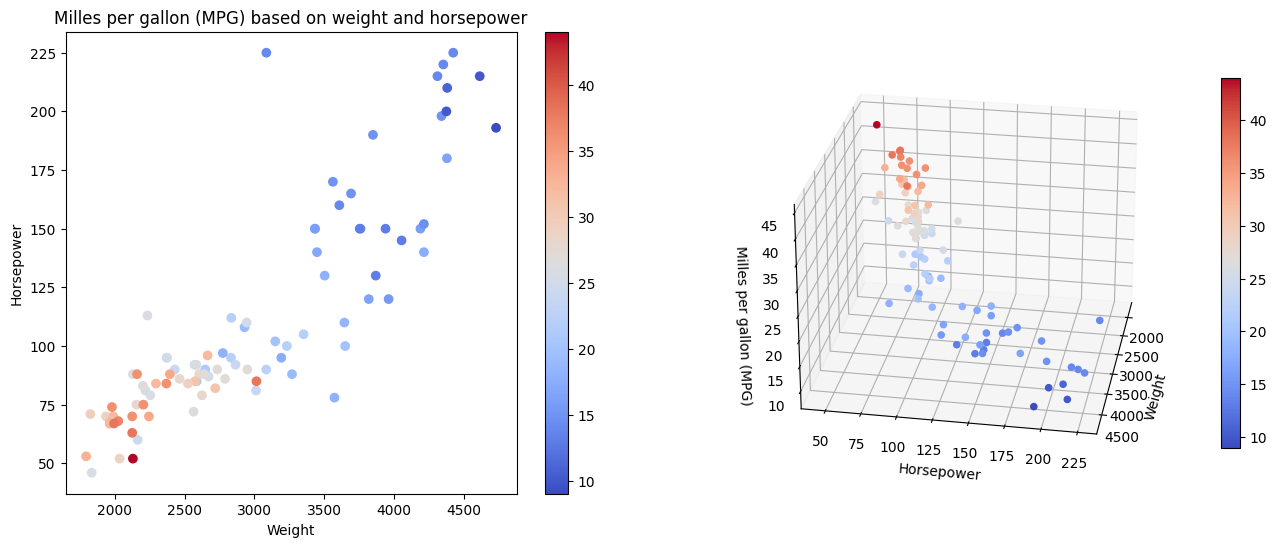

In [5]:
# Show the data
plot_data(x_data, y_data)

## Least square regression model

We will use the least square regression to create a model that predicts the fuel consumption of a car based on its weight and horsepower. The least squares regression model allows to find the best-fitting hyperplane (in the case of multiple linear regression) that minimizes the sum of the squared differences between the observed and predicted values of the dependent variable.

Therefore, this model will be used as a baseline to compare against the final MLP model.

Model MSE: 16.009266139734542


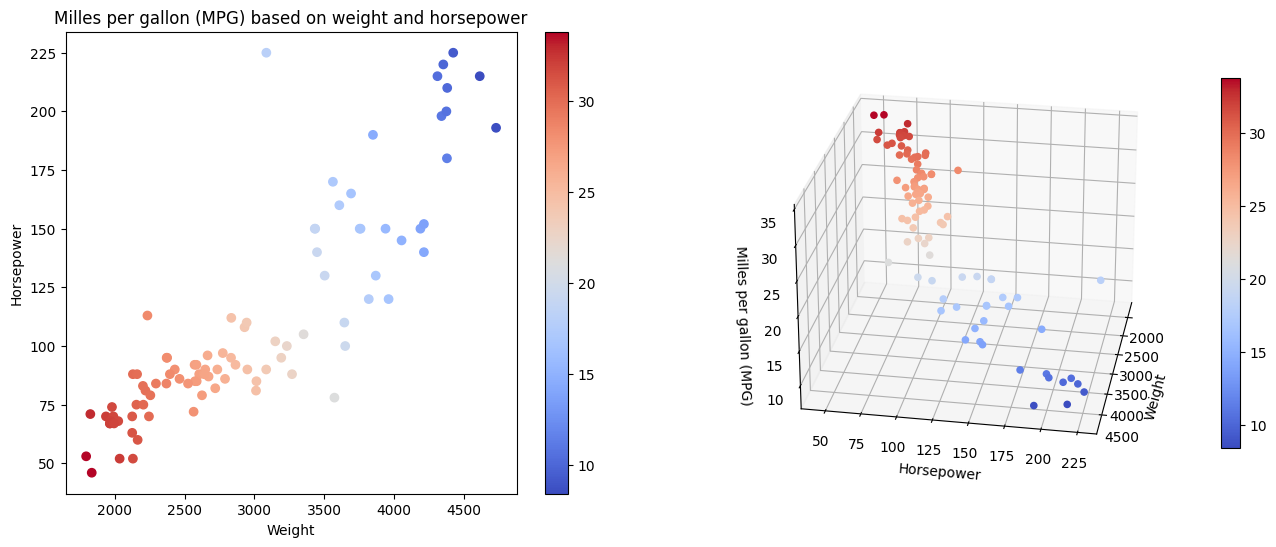

In [6]:
from sklearn.linear_model import LinearRegression

# Train a linear regression model
model = LinearRegression()
model.fit(x_data, y_data)
y = model.intercept_ + model.coef_[0] * x_data[:,0] + model.coef_[1] * x_data[:,1] # Model formula

# Show the model results
print("Model MSE:", mean_squared_error(y_data, y))
plot_data(x_data, y)

### Visualize the decision surface

The decision surface allows us to visualize the behavior of the model. In this case, we will use a decision surface (displayed as a contour) that we will use to compare against our final regression model.

In [7]:
def rotating_plot(title, callback, plots=3, elev_vals=[15, 20, 25], azim_vals=[30, 15, 0]):
    """
    Displays a 3D plot of the data with different rotations.
    :param callback: Function that receives the axis as parameter.
    """
    fig = plt.figure(figsize=(16, 6))
    plot_title_pos = plots // 2 if plots % 2 == 0 else plots // 2 + 1
    for i in range(plots):
        ax = fig.add_subplot(1, plots, i+1, projection='3d')
        callback(ax)
        if plot_title_pos == i+1:
            ax.set_title(title)
        ax.view_init(elev=elev_vals[i], azim=azim_vals[i])
    plt.show()

In [8]:
def decision_surface(
        x_data: np.ndarray,
        y_data: np.ndarray,
        prediction_callback: Callable[[np.ndarray], np.ndarray],
        surface_margin=10):
    """
    Shows the decision surface for a set of data (only works with 2 features).
    :param x_data: Input data.
    :param y_data: Output data.
    :param prediction_callback: Function that receives the input surface data of the feature space (x_data_surface) and returns the prediction for each point.
    """
    x1_data = x_data[:,0]
    x2_data = x_data[:,1]

    # Define the range of the feature space
    x1_min, x1_max = x1_data.min() - surface_margin, x1_data.max() + surface_margin
    x2_min, x2_max = x2_data.min() - surface_margin, x2_data.max() + surface_margin
    x1_vals, x2_vals = np.meshgrid(
        np.arange(x1_min, x1_max, 10),
        np.arange(x2_min, x2_max, 10)
    )

    # Predict the output for each point in the feature space
    x_data_surface = np.c_[x1_vals.ravel(), x2_vals.ravel()]
    y_pred = prediction_callback(x_data_surface)
    y_pred = y_pred.reshape(x1_vals.shape)

    # Plot the decision surface
    def decision_surface_plot(ax):
        ax.plot_surface(x1_vals, x2_vals, y_pred, cmap='coolwarm', alpha=0.7)
        ax.scatter(x1_data, x2_data, y_data, c=y_data, cmap='coolwarm', edgecolor='black', s=20, alpha=0.8)
        ax.set_xlabel('Weight')
        ax.set_ylabel('Horsepower')
        ax.set_zlabel('MPG')
    rotating_plot("Decision Surface", decision_surface_plot)

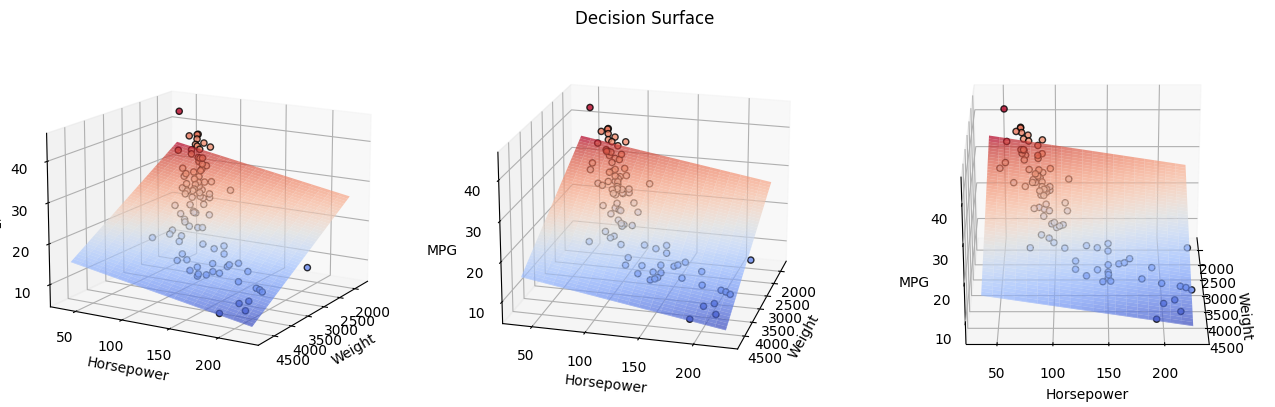

In [9]:
# Show the decision surface
decision_surface(x_data, y_data, lambda x: model.predict(x))

We can observe that the decision surface is a plane that fits the data. However, we can see that the model is not able to fit the data perfectly, which is expected because the data is not linearly separable (we achieved a $MSE \approx 16$).

## Scale the data

In order to improve the performance of our model, we will scale the data using MinMaxScaler. This will allow us to transform the data so that it is in the range $[0, 1]$ and therefore, the model will be able to learn better.

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Scale the input data
x_scaler = MinMaxScaler()
x_data_scaled = x_scaler.fit_transform(x_data)

# Scale the output data
y_scaler = MinMaxScaler()
y_data_scaled = y_scaler.fit_transform(y_data.reshape(-1, 1))

# Show the scaled data
print("Scaled data sample:")
data_scaled_df = pd.DataFrame(
    np.concatenate((x_data_scaled, y_data_scaled), axis=1),
    columns=['X1_Weight', 'X2_Horsepower', 'Y_MPG']
)
data_scaled_df[:10]

Scaled data sample:


,X1_Weight,X2_Horsepower,Y_MPG
0,0.581886,0.469274,0.257143
1,0.646238,0.664804,0.171429
2,0.558733,0.581006,0.257143
3,0.557712,0.581006,0.200000
4,0.563160,0.525140,0.228571
5,0.866871,0.849162,0.171429
6,0.871297,0.972067,0.142857
7,0.856997,0.944134,0.142857
8,0.895472,1.000000,0.142857
9,0.699694,0.804469,0.171429


## Split the data

Now, we will split the data into training and test sets. We will use 80% of the data for training and 20% for testing, a commonly used ratio for splitting the data (Joseph, 2022). This will allow us to evaluate the overall performance of our model.

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data_scaled, test_size=0.2)

## Network training

A multilayer perceptron (MLP) is a feed-forward neural network architecture composed of multiple layers of McCulloch-Pitts neurons.

The McCulloch-Pitt neuron is a binary activation model that either fires or not based on a fixed threshold. It has excitatory connections with positive weights and inhibitory connections with negative weights, which simulate the behavior of a biological neuron (Chakraverty et al., 2019).

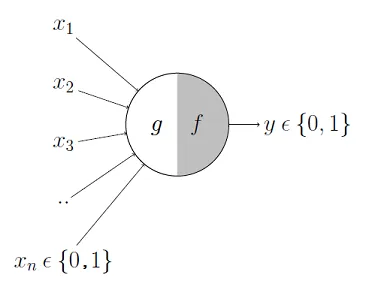

*Mcculloch-Pitts neuron (Chandra, 2022)*

For regression tasks, MLP is trained to map an input vector to a given set of values. The MLP's ability to perform nonlinear regression allows it to capture complex relationships in the data (Murtagh, 1991).

We will use a MLP with 1 hidden layer and a logistic activation function for training the model. The logistic activation function defined as $f(x) = \frac{1}{1 + e^{-x}}$ is commonly used in MLPs as the transfer function for the hidden layer neurons (Murtagh, 1991).

In [12]:
import warnings
warnings.filterwarnings('ignore')

def mlp(
        r_i, # Input patterns
        r_d, # Desired output patterns
        N_i, # Number of input neurons
        N_h, # Number of hidden neurons (single hidden layer with N reurons)
        N_o, # Number of output neurons
        training_steps=1000, # Number of training steps
        lr=0.5, # Learning rate
        batch_size=1 # Batch size
    ):
    """"Function to train a multilayer perceptron (MLP) for regression using the logistic activation function."""

    # Initialize randomly the weights
    # Hidden layer
    w_h = np.random.rand(N_h+1, N_i) - 0.5
    # Output layer
    w_o = np.random.rand(N_o, N_h+1) - 0.5

    mse = []

    for ti in range(training_steps):
        # Select training pattern randomly
        for bi in range(batch_size):
            # Feed-forward the input to hidden layer
            i = np.floor(np.shape(r_i)[1]*np.random.rand()).astype('int')
            r_h = 1 / (1 + np.exp(-w_h*r_i[:, i]))
            r_h[-1] = 1  # Bias from hidden to output layer
            # Feed-forward the input to the output layer
            r_o = 1 / (1 + np.exp(-w_o*r_h))
            # Calculate the network error
            d_o = np.multiply(np.multiply(r_o, 1-r_o), r_d[:, i] - r_o)
            # Calculate the responsability of the hidden network in the error
            d_h = np.multiply(np.multiply(r_h, (1-r_h)), (w_o.T*d_o))
            # Update weights
            w_o = w_o + lr*(r_h*d_o.T).T
            w_h = w_h + lr*(r_i[:, i]*d_h.T).T

        # Test all patterns
        rht = 1 / (1 + np.exp(-w_h*r_i))
        rht[-1] = 1
        r_o_test = 1 / (1 + np.exp(-w_o*rht))
        mse += [mean_squared_error(np.asarray(r_d), np.asarray(r_o_test))]

    return mse, r_o_test, w_h, w_o

### Results with non-optimal hyperparameters

We will show the overall performance of the model by displaying the error evolution over the training epochs, for a non-optimal set of hyperparameters.

In this case, we will use the following hyperparameters:
- **Number of hidden neurons**: 10
- **Learning rate**: 0.2
- **Batch size**: 2

In [13]:
def plot_mse_evolution(mse: list):
    """Plots the error evolution (MSE) over the training steps."""
    plt.figure(figsize=(12, 6))
    plt.title('MSE evolution')
    plt.xlabel('Training steps')
    plt.ylabel('MSE')
    plt.plot(mse)
    plt.show()

In [14]:
# Train the model
mse, r_o_test, w_h, w_o = mlp(np.matrix(x_train.T), np.matrix(y_train.T), 2, 10, 1, lr=0.2, batch_size=2)

Model MSE: 0.028172622969885968


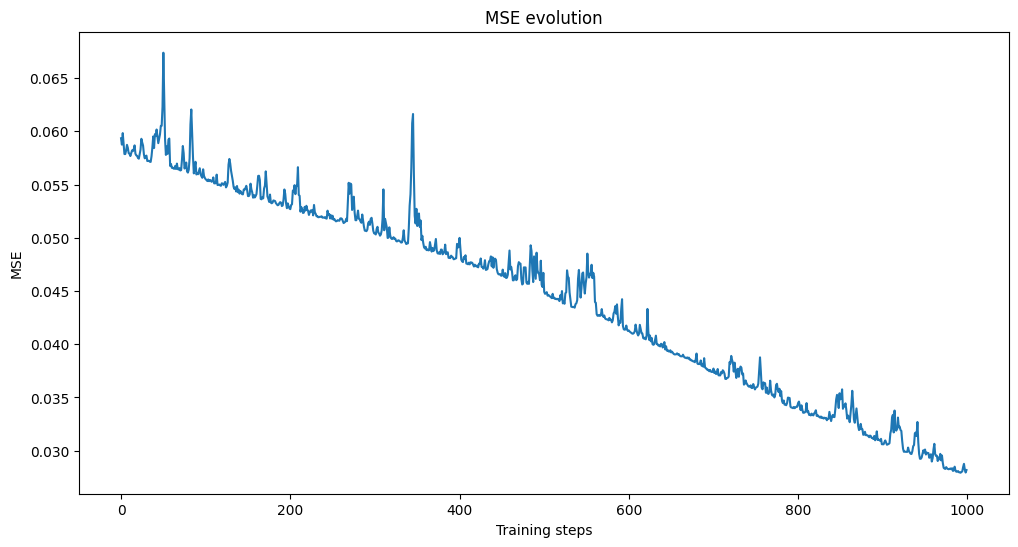

In [15]:
print("Model MSE:", mse[-1])
plot_mse_evolution(mse)

We can observe that the error decreases over the training epochs, which means that the model is learning. However, we can see that the error is still high ($MSE \approx 0.028$), which means that the model is not able to fit the data correctly.

## Network prediction

In [16]:
def mlp_predict(
        r_i, # Input patterns
        w_h, # Hidden layer weights
        w_o # Output layer weights
    ):
    """Function to predict the output of a multilayer perceptron (MLP) for regression."""
    rht = 1 / (1 + np.exp(-w_h*r_i))
    rht[-1] = 1
    r_o_test = 1 / (1 + np.exp(-w_o*rht))
    return np.asarray(r_o_test)

In [17]:
def unscale_output(y_scaler: MinMaxScaler, value: float):
    """
    Unscales the output value using the given scaler.
    Returns the unscaled value.
    """
    reshaped_value = np.array(value).reshape(-1, 1)
    return y_scaler.inverse_transform(reshaped_value).reshape(-1)[0]

unscale_output_vectorized = np.vectorize(unscale_output) # Vectorized version of the function

In [18]:
# Make predictions
prediction_result = mlp_predict(np.matrix(x_test.T), w_h, w_o)

# Calculate the MSE
y_pred = prediction_result.reshape(-1,1)
print("Model predictions MSE:", mean_squared_error(y_test, y_pred))

# Show the model results
unscaled_predicted_values = unscale_output_vectorized(y_scaler, prediction_result[0])
unscaled_test_values = unscale_output_vectorized(y_scaler, y_test.T[0])
pd.DataFrame({
    'Predicted': unscaled_predicted_values,
    'Actual': unscaled_test_values
})[:10]

Model predictions MSE: 0.025237776514524392


,Predicted,Actual
0,21.036748,17.5
1,21.945855,13.0
2,25.239488,22.0
3,26.551851,26.5
4,22.459562,18.0
5,22.466232,16.0
6,24.725358,22.5
7,26.446301,24.0
8,25.963727,26.0
9,24.570582,25.0


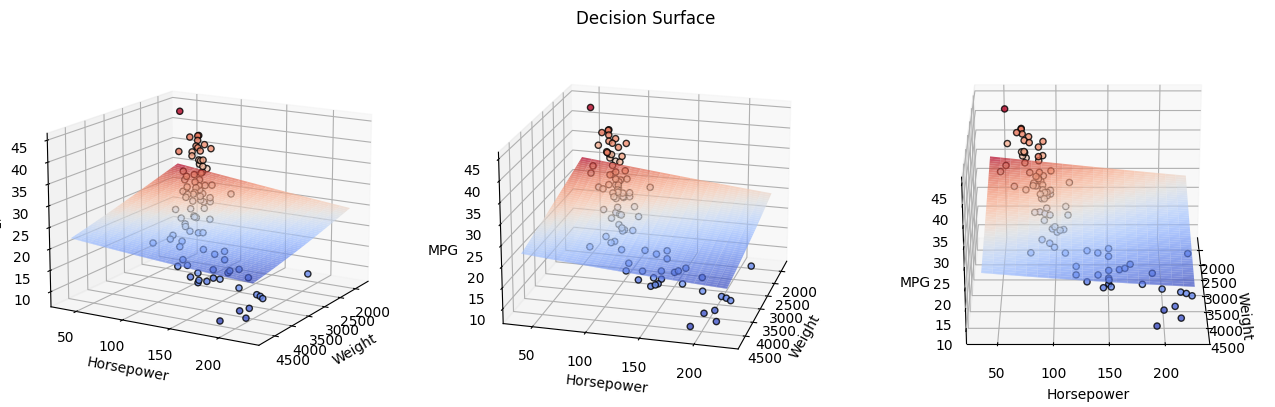

In [19]:
# Show the decision surface
def prediction_callback(x_data_surface):
    x_data_scaled = x_scaler.transform(x_data_surface)
    y_pred = mlp_predict(np.matrix(x_data_scaled.T), w_h, w_o)
    y_pred = unscale_output_vectorized(y_scaler, y_pred)
    return y_pred
decision_surface(x_data, y_data, lambda x: prediction_callback(x))

We can also observe that the resulting decision surface for the model trained with non-optimal parameters remains very similar to a plane.

## Hyperparameter tuning

Hyperparameters influence how the parameters are learned by our model, and choosing good hyperparameters can be crucial for achieving good performance on a given task (Melanee Group, 2023). Therefore, we will tune the hyperparameters of our model to improve its performance.

For each hyperparameter, we will train a model with different values of that hyperparameter and evaluate the model performance against the test data. We will select the hyperparameter value that achieves the best performance on the test data.

The hyperparameters we will tune are:
- **Number of hidden neurons**: the number of neurons in the hidden layer.
- **Batch size**: the number of training examples used in each iteration of the gradient descent algorithm.
- **Learning rate**: the learning rate of the gradient descent algorithm.

The **training steps** (number of iterations) will be fixed to $1000$ epochs.

In [20]:
# Hyperparameters values to test
Nh_vals = np.arange(2, 40, 4)
batch_size_vals = np.arange(1, 20, 2)
lr_vals = np.arange(0.1, 1, 0.1)

# Calculate the amount of possible combinations
n_combinations = len(Nh_vals) * len(batch_size_vals) * len(lr_vals)
print("Number of combinations:", n_combinations)

Number of combinations: 900


In [21]:
r_i_train = np.matrix(x_train.T)
r_d_train = np.matrix(y_train.T)
r_i_test = np.matrix(x_test.T)

# Test all combinations
count = 0
log_freq = 100
training_mse_vals = []
testing_mse_vals = []
hyperparameters_combinations = []
model_results = []
for n_h in Nh_vals:
    for batch_size in batch_size_vals:
        for lr in lr_vals:
            count += 1
            # Train the model
            train_result = mlp(r_i_train, r_d_train, 2, n_h, 1, lr=lr, batch_size=batch_size)
            training_mse_vals.append(train_result[0][-1])
            hyperparameters_combination = (n_h, batch_size, lr)
            hyperparameters_combinations.append(hyperparameters_combination)
            model_results.append(train_result)
            # Test the model
            prediction_result = mlp_predict(r_i_test, train_result[2], train_result[3])
            y_pred = prediction_result.reshape(-1,1)
            testing_mse_vals.append(mean_squared_error(y_test, y_pred))
            if count % 100 == 0:
                print("Combination", count, "of", n_combinations)
                print(
                    "Hidden neurons:", n_h, 
                    "; Batch size:", batch_size, 
                    "; Learning rate:", lr, 
                    "; Training MSE:", training_mse_vals[-1],
                    "; Testing MSE:", testing_mse_vals[-1]
                )

Combination 100 of 900
Hidden neurons: 6 ; Batch size: 3 ; Learning rate: 0.1 ; Training MSE: 0.04541243210857237 ; Testing MSE: 0.03520480333010116
Combination 200 of 900
Hidden neurons: 10 ; Batch size: 5 ; Learning rate: 0.2 ; Training MSE: 0.01191365114468793 ; Testing MSE: 0.013819531190157287
Combination 300 of 900
Hidden neurons: 14 ; Batch size: 7 ; Learning rate: 0.30000000000000004 ; Training MSE: 0.01105592588016724 ; Testing MSE: 0.014237537538998604
Combination 400 of 900
Hidden neurons: 18 ; Batch size: 9 ; Learning rate: 0.4 ; Training MSE: 0.010974591005955884 ; Testing MSE: 0.014396339053472446
Combination 500 of 900
Hidden neurons: 22 ; Batch size: 11 ; Learning rate: 0.5 ; Training MSE: 0.01285663785145373 ; Testing MSE: 0.014963474128487983
Combination 600 of 900
Hidden neurons: 26 ; Batch size: 13 ; Learning rate: 0.6 ; Training MSE: 0.014952701929135385 ; Testing MSE: 0.01632971741864565
Combination 700 of 900
Hidden neurons: 30 ; Batch size: 15 ; Learning rate: 0

### Overall results

In [22]:
# Dataframe with the results
results = pd.DataFrame({
    'Hidden Neurons': [x[0] for x in hyperparameters_combinations],
    'Batch Size': [x[1] for x in hyperparameters_combinations],
    'Learning Rate': [x[2] for x in hyperparameters_combinations],
    'Training MSE': training_mse_vals,
    'Testing MSE': testing_mse_vals,
    'Model': model_results
})
print("Average training MSE:", results['Training MSE'].mean())
print("Average testing MSE:", results['Testing MSE'].mean())
results.drop('Model', axis=1).sort_values(by='Testing MSE', ascending=True)[:10] # Show the best 10 results

Average training MSE: 0.013541005763493673
Average testing MSE: 0.016283655872914717


,Hidden Neurons,Batch Size,Learning Rate,Training MSE,Testing MSE
192,10,3,0.4,0.011267,0.013394
585,26,11,0.1,0.011459,0.013492
112,6,5,0.5,0.011499,0.013551
217,10,9,0.2,0.011170,0.013583
102,6,3,0.4,0.011587,0.013612
307,14,9,0.2,0.011312,0.013614
829,38,5,0.2,0.011126,0.013670
731,34,3,0.3,0.011428,0.013672
16,2,3,0.8,0.012023,0.013712
153,6,15,0.1,0.011171,0.013720


### Best hyperparameters results

Training MSE: 0.011266621258351945
Testing MSE: 0.013394279467571976
Hyperparameters:
- Number of hidden neurons: 10
- Batch size: 3
- Learning rate: 0.4


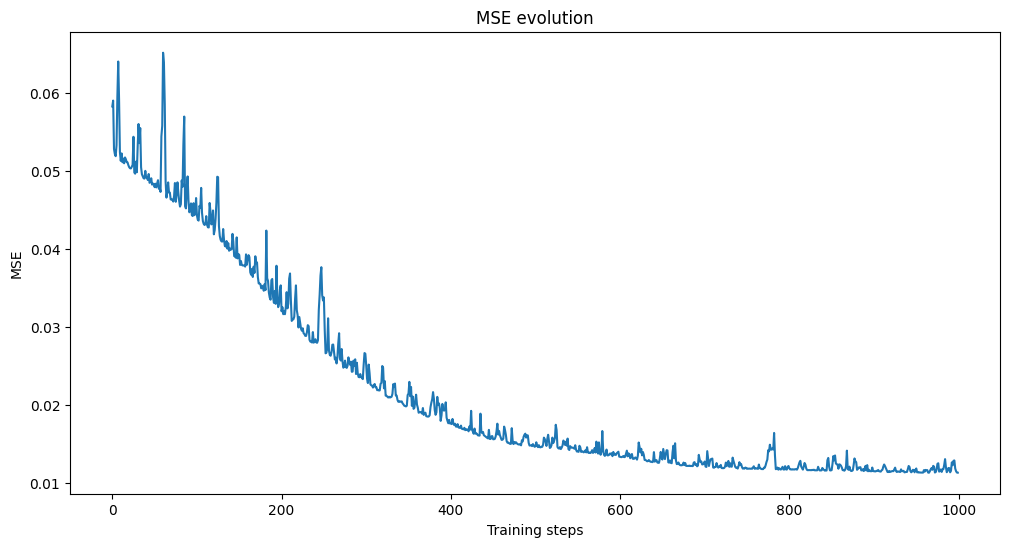

In [23]:
best_result = results.sort_values(by=['Testing MSE']).iloc[0]
print("Training MSE:", best_result['Training MSE'])
print("Testing MSE:", best_result['Testing MSE'])
print("Hyperparameters:")
print("- Number of hidden neurons:", best_result['Hidden Neurons'])
print("- Batch size:", best_result['Batch Size'])
print("- Learning rate:", best_result['Learning Rate'])
plot_mse_evolution(best_result['Model'][0])

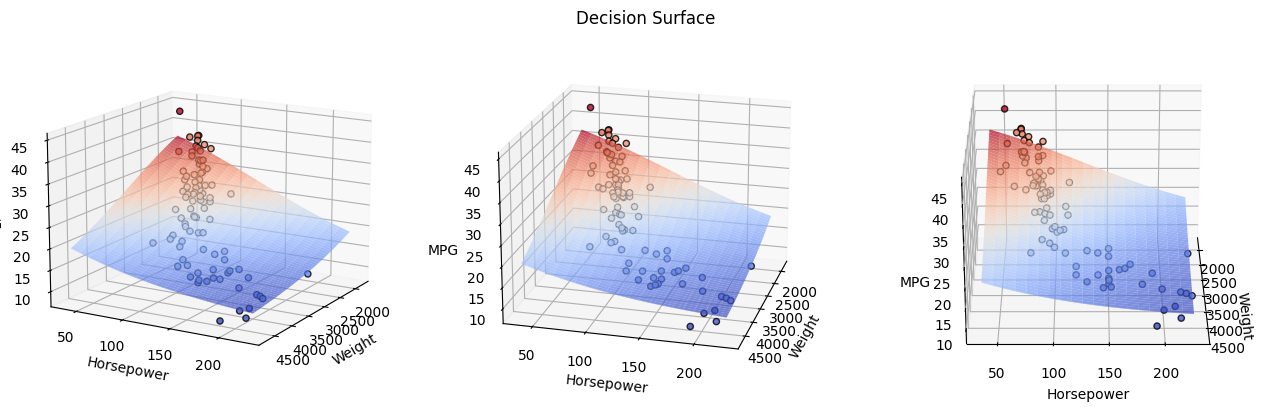

In [24]:
# Show the decision surface
def prediction_callback(x_data_surface):
    x_data_scaled = x_scaler.transform(x_data_surface)
    y_pred = mlp_predict(np.matrix(x_data_scaled.T), best_result['Model'][2], best_result['Model'][3])
    y_pred = unscale_output_vectorized(y_scaler, y_pred)
    return y_pred
decision_surface(x_data, y_data, lambda x: prediction_callback(x))

### Worst hyperparameters results

Training MSE: 0.05640627133764829
Testing MSE: 0.05032594659779202
Hyperparameters:
- Number of hidden neurons: 10
- Batch size: 1
- Learning rate: 0.1


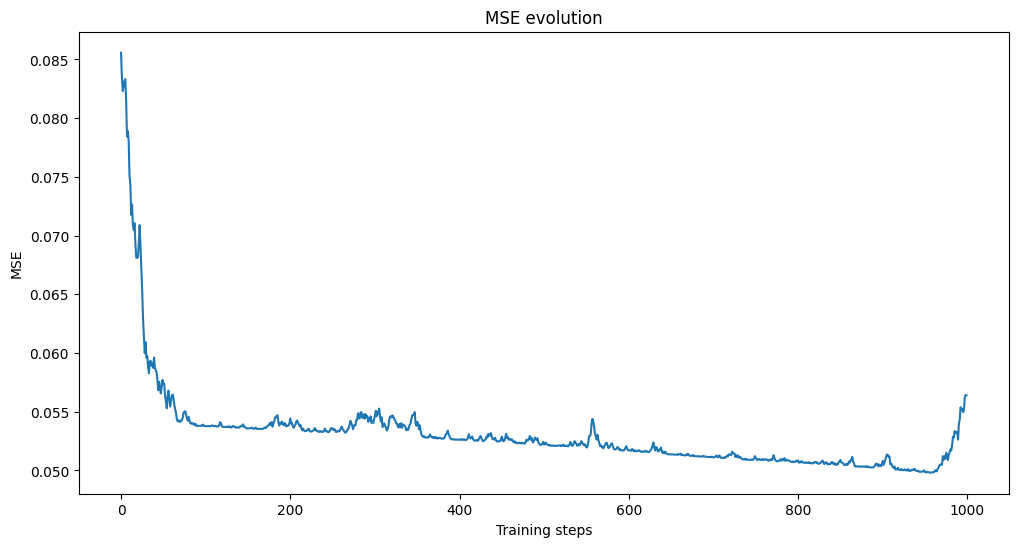

In [25]:
worst_result = results.sort_values(by=['Testing MSE']).iloc[-1]
print("Training MSE:", worst_result['Training MSE'])
print("Testing MSE:", worst_result['Testing MSE'])
print("Hyperparameters:")
print("- Number of hidden neurons:", worst_result['Hidden Neurons'])
print("- Batch size:", worst_result['Batch Size'])
print("- Learning rate:", worst_result['Learning Rate'])
plot_mse_evolution(worst_result['Model'][0])

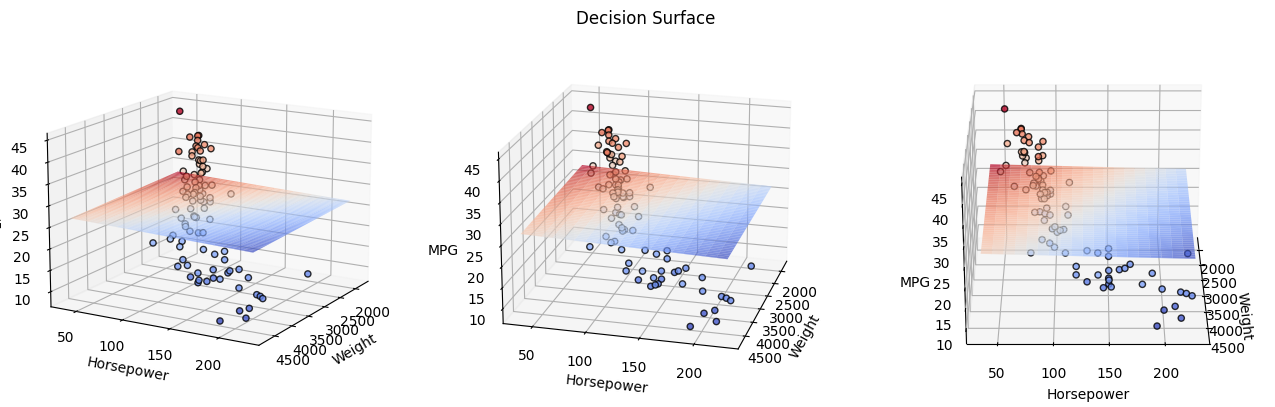

In [26]:
# Show the decision surface
def prediction_callback(x_data_surface):
    x_data_scaled = x_scaler.transform(x_data_surface)
    y_pred = mlp_predict(np.matrix(x_data_scaled.T), worst_result['Model'][2], worst_result['Model'][3])
    y_pred = unscale_output_vectorized(y_scaler, y_pred)
    return y_pred
decision_surface(x_data, y_data, lambda x: prediction_callback(x))

After tuning the hyperparameters, we can see that the model trained with the best hyperparameters achieves the lowest error ($MSE \approx 0.013$ on test data), with the following configuration:
- **Number of hidden neurons**: 10
- **Learning rate**: 0.4
- **Batch size**: 3

On the other hand, the model trained with the worst hyperparameters achieves the highest error ($MSE \approx 0.050$ on test data), with the following configuration:
- **Number of hidden neurons**: 10
- **Learning rate**: 0.1
- **Batch size**: 1

We can also observe that the decision surface for the model trained with the best hyperparameters is more complex than the decision surface for the model trained with the worst hyperparameters, which resembles a plane. This means that the model trained with the best hyperparameters is able to fit the data better than the model trained with the worst hyperparameters and therefore, it achieves a lower error.

It is important to note that finding the optimal combination of hyperparameters is often a complex and time-consuming process. In order to find this best combination, we usually use techniques such as grid search, random search or Bayesian optimization, which help us to systematically explore different combinations and select the one that results in the best performance.

## Overfitting analysis

One of the main causes of overfitting is the complexity of the model. We will analyze the effect of the training steps on the overfitting of the model, by comparing the MSE of the training and test data. 

For this purpose, we will increase the number of training steps to add more complexity to the model, and we will plot the error evolution for the training and test data to see if the model is overfitting.

The remaining hyperparameters will be fixed to the best values found in the previous section.

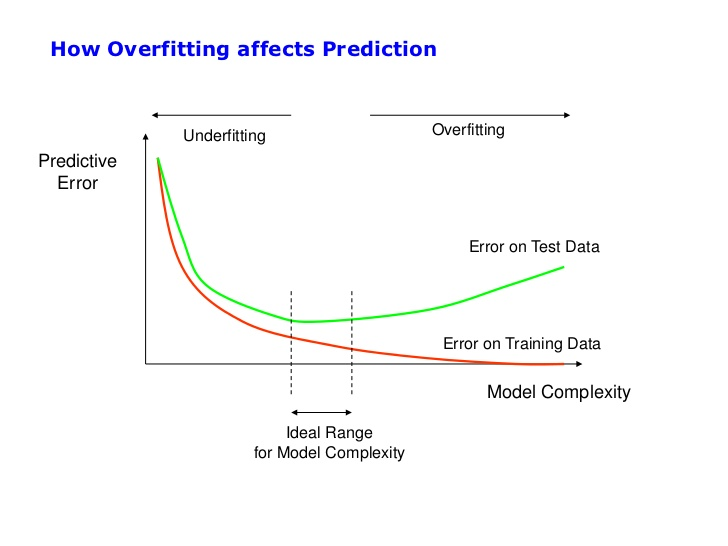

*Overfitting influence over the overall performance of the model (López, 2022)*

In [32]:
# Hyperparameters values
n_h = best_result['Hidden Neurons']
lr = best_result['Learning Rate']
batch_size = best_result['Batch Size']
training_steps_vals = [10, 100, 1000, 10000, 100000]

In [33]:
r_i_train = np.matrix(x_train.T)
r_d_train = np.matrix(y_train.T)
r_i_test = np.matrix(x_test.T)

# Test model overfitting
training_mse_vals = []
testing_mse_vals = []
model_results = []
for training_steps in training_steps_vals:
    # Train the model
    train_result = mlp(r_i_train, r_d_train, 2, n_h, 1, lr=lr, batch_size=batch_size, training_steps=training_steps)
    training_mse_vals.append(train_result[0][-1])
    model_results.append(train_result)
    # Test the model
    prediction_result = mlp_predict(r_i_test, train_result[2], train_result[3])
    y_pred = prediction_result.reshape(-1,1)
    testing_mse_vals.append(mean_squared_error(y_test, y_pred))

    print(
        "Training Steps:", training_steps,
        "; Training MSE:", training_mse_vals[-1],
        "; Testing MSE:", testing_mse_vals[-1]
    )

Training Steps: 10 ; Training MSE: 0.0577777264674576 ; Testing MSE: 0.04635795893616973
Training Steps: 100 ; Training MSE: 0.05900950583391609 ; Testing MSE: 0.05140063453570766
Training Steps: 1000 ; Training MSE: 0.011262005719552595 ; Testing MSE: 0.014019667835154992
Training Steps: 10000 ; Training MSE: 0.011299930074660656 ; Testing MSE: 0.013999889830280832
Training Steps: 100000 ; Training MSE: 0.010886809540025098 ; Testing MSE: 0.014404695272341365


In [34]:
# Dataframe with the results
results = pd.DataFrame({
    'Training Steps': training_steps_vals,
    'Training MSE': training_mse_vals,
    'Testing MSE': testing_mse_vals,
    'Model': model_results
})
results.drop('Model', axis=1)

,Training Steps,Training MSE,Testing MSE
0,10,0.057778,0.046358
1,100,0.059010,0.051401
2,1000,0.011262,0.014020
3,10000,0.011300,0.014000
4,100000,0.010887,0.014405


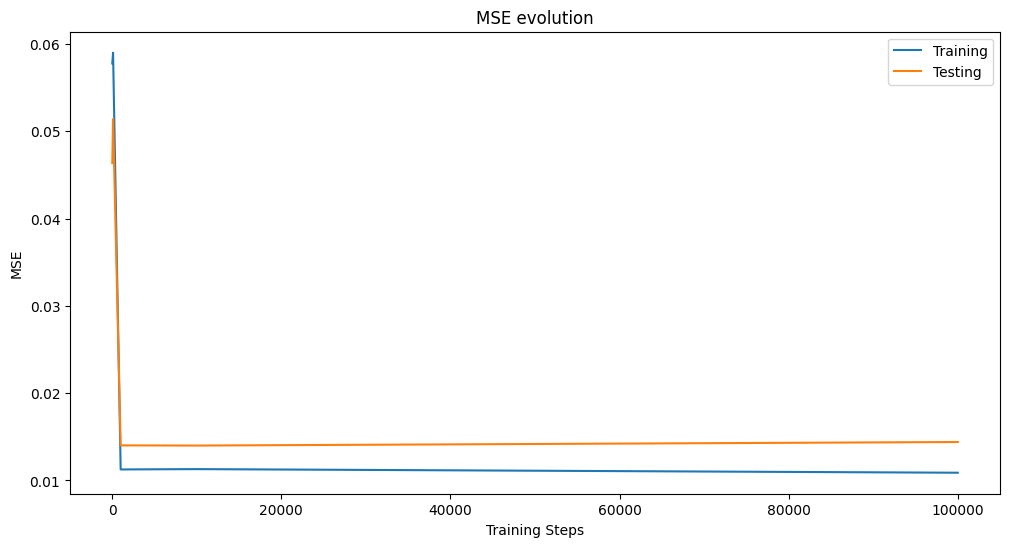

In [36]:
# Results of the evolution of the MSE over the training steps and the testing MSE
plt.figure(figsize=(12, 6))
plt.title('MSE evolution')
plt.xlabel('Training Steps')
plt.ylabel('MSE')
plt.plot(results['Training Steps'], results['Training MSE'], label='Training')
plt.plot(results['Training Steps'], results['Testing MSE'], label='Testing')
plt.legend()
plt.plot();

We can observe that the model is overfitting when the number of training steps achieves $100000$, because the error for the training data is decreasing while the error for the test data starts increasing compared to the previous amount of training steps. This means that the model is learning the training data too well and therefore, it is not able to generalize well to unseen data.

However, we must notice that the overfitting is very smooth for this model with the selected configuration of hyperparameters, when the number of training steps is increased.

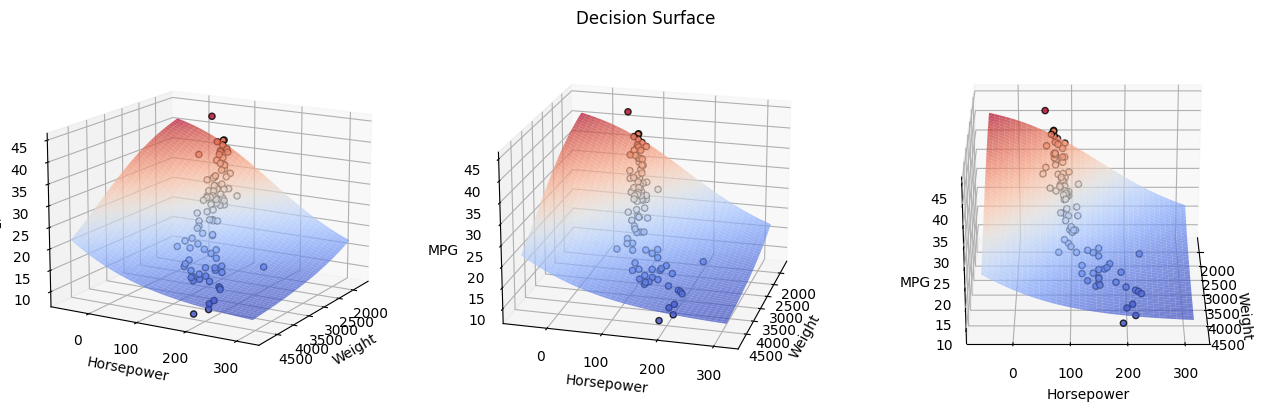

In [37]:
# Show the decision surface
overfitting_result = results.iloc[-1]
def prediction_callback(x_data_surface):
    x_data_scaled = x_scaler.transform(x_data_surface)
    y_pred = mlp_predict(np.matrix(x_data_scaled.T), overfitting_result['Model'][2], overfitting_result['Model'][3])
    y_pred = unscale_output_vectorized(y_scaler, y_pred)
    return y_pred
decision_surface(x_data, y_data, lambda x: prediction_callback(x), surface_margin=100)

### ¿Which hyperparameters combination is the best?

When we perform hyperparameter optimization, it is crucial to keep in mind the balance between the model's complexity and its ability to generalize with new or unseen data. Overfitting occurs when the model becomes too complex and performs great on the training data but poorly on new data. This is why, when selecting the best combination of hyperparameters, we not only seek the lowest error on the test data but also a model that is not overfitting.

In this case, the best hyperparameters combination identified (10 hidden neurons, learning rate of 0.4, and batch size of 3) achieves the lowest mean squared error ($MSE \approx 0.013$) on the test dataset and manages to avoid overfitting. This allows our model to have a strong generalization capability, making it more likely to perform well when applied to new data.

Therefore, the best combination of hyperparameters for an MLP regression model is the one that minimizes the error on the test data while preventing overfitting, which ensures a good generalization capability (good model performance on new data).

It is also important to notice that finding the ideal hyperparameters combination typically involves exploring different sets of hyperparameters and using techniques like cross-validation to evaluate the model's performance objectively. This process might be computationally demanding and time-consuming, but it is essential to develop models that can make predictions with high accuracy and reliability.

## References

- Chakraverty, S., Sahoo, D.M., Mahato, N.R. (2019). *McCulloch–Pitts Neural Network Model*. Concepts of Soft Computing. Springer, Singapore. https://doi.org/10.1007/978-981-13-7430-2_11
- Chandra, A. L. (2022, 27 septiembre). *McCulloch-Pitts Neuron — Mankind’s First Mathematical Model Of A Biological Neuron*. Medium. https://towardsdatascience.com/mcculloch-pitts-model-5fdf65ac5dd1
- Joseph, V. R. (2022). *Optimal ratio for data splitting*. Statistical Analysis and Data Mining, 15(4), 531-538. https://doi.org/10.1002/sam.11583 
- López, J. (2023). *Overfitting & Hyperparameter Tuning with Cross Validation*. Resolving Python. https://blog.resolvingpython.com/04-overfitting-hyperparameter-tuning-with-cross-validation
- Melanee Group. (2023). A Comprehensive Analysis of Hyperparameter Optimization in Logistic Regression Models. https://levelup.gitconnected.com/a-comprehensive-analysis-of-hyperparameter-optimization-in-logistic-regression-models-521564c1bfc0 
- Murtagh, F. (1991). *Multilayer perceptrons for classification and regression*. Neurocomputing, 2(5-6), 183-197. https://doi.org/10.1016/0925-2312(91)90023-5 
- Ramchoun, H., Amine, M., Idrissi, J., Ghanou, Y., & Ettaouil, M. (2016). *Multilayer Perceptron: Architecture Optimization and Training*. International Journal of Interactive Multimedia and Artificial Intelligence, 4(1), 26. https://doi.org/10.9781/ijimai.2016.415